# Getting data from supermetrics

Follow tutorial https://supermetrics.com/blog/how-to-load-data-into-mysql

Urls are stored in 'constants.py', which will not be pushed into the repo. Urls contain the supermetrics queries for different timeframes in 2021. At first, just basic information (client IDs, transaction yes/no + transaction amount) are imported

## TODOS - if necessary 

* Plots with different channels - split into different plots (one plot per channel), to be able to see differences 
* Check percentage of clients/transactions per channel 
    - whole year 
    - #GivingTuesday 
* Plots/tables of clients/transactions per channel and hozur (?)/day/week/month 
* Figure out emails or specific campaigns - how are they influencing the results? 
* Impute missing data in empty channels (see youtube ads)
* plot of channels vs transactions revenue 
* check ratio unique clients ID / transactions 
    - per day 
    - on giving Tuesday 
    - per channel group 

## Basic data - client IDs & transactions

In [4]:
import requests
import urllib.parse as up
import json
from pandas.io.json import json_normalize
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 

import constants_MT

In [5]:
# import urls 
url_1month = constants_MT.url_1month
url_3months = constants_MT.url_3months
url_6months = constants_MT.url_6months
url_12months = constants_MT.url_12months
url_last3months = constants_MT.url_last3months
#print(url_1month)

In [6]:
# call API - necessary to access data 
response_1month = requests.get(url_1month)
response_3months = requests.get(url_3months)
response_6months = requests.get(url_6months)
response_12months = requests.get(url_12months)
response_last3months = requests.get(url_last3months)

In [7]:
# check response from supermetrics 
# response needs to be positive to access data 
responses = [response_1month, response_3months, response_6months, response_12months, response_last3months]

for r in responses:
    print(r)

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>


In [8]:
# function to create dataframe from url data 
def url_to_df (url, response): 
    """
    Function to create pandas dataframe from url data. Imported data needs 
    to be of type json or keyjson. Otherwise an exception error is thrown

    Arguments: 
        url: url previously imported from constants file 
        response: previously extracted response 

    Returns: 
        df2: supermetrics information transformed into pandas dataframe 
    """

    if 'data/json?' in url:
        # convert json into pandas df 
        data = json.loads(json.dumps(response.json()))
        df = pd.DataFrame.from_dict(data['data'])
        headers = df.iloc[0]
        df2 = pd.DataFrame(df.values[1:], columns=headers)
    elif 'data/keyjson?' in url:
        # convert json key-value pair output to pandas df 
        df2 = pd.read_json(json.dumps(response.json()))
    else:
        # throw exception message 
        import sys
        sys.exit("DEFINE JSON OR KEYJSON AS OUTPUT FORMAT: https://supermetrics.com/docs/product-api-output-formats/")
    return df2     

In [9]:
# create dataframes of different time ranges - for year 2021 
df_1month = url_to_df(url_1month, response_1month)
df_3months = url_to_df(url_3months, response_3months)
df_6months = url_to_df(url_6months, response_6months)
df_12months = url_to_df(url_12months, response_12months)
df_last3months = url_to_df(url_last3months, response_last3months)

In [10]:
# function to convert data to correct format
def transform_class (df):
    # to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # to numeric 
    df['Users'] = pd.to_numeric(df['Users'],errors = 'coerce')
    df['Transactions'] = pd.to_numeric(df['Transactions'],errors = 'coerce')
    df['Transaction revenue'] = pd.to_numeric(df['Transaction revenue'],errors = 'coerce')
    
    return (df)

In [11]:
df_1month = transform_class(df_1month)
df_3months = transform_class(df_3months)
df_6months = transform_class(df_6months)
df_12months = transform_class(df_12months)
df_last3months = transform_class(df_last3months)

## Data with more features 

TODO 

# Descriptive analysis - deciding on time range to work with

Work with complete 2021 year 

Very imbalanced dataset (as expected)

In [12]:
print("Number of clients in January 2021:", len(df_1month))
print("Number of transactions in January 2021:", sum(df_1month['Transactions']))

print("Number of clients in January-March 2021:", len(df_3months))
print("Number of transactions in January-March 2021:", sum(df_3months['Transactions']))

print("Number of clients in January-June 2021:", len(df_6months))
print("Number of transactions in January-June 2021:", sum(df_6months['Transactions']))

print("Number of clients in January-December 2021:", len(df_12months))
print("Number of transactions in January-December 2021:", sum(df_12months['Transactions']))

print("Number of clients in October-December 2021:", len(df_last3months))
print("Number of transactions in October-December 2021:", sum(df_last3months['Transactions']))

Number of clients in January 2021: 111074
Number of transactions in January 2021: 683
Number of clients in January-March 2021: 168709
Number of transactions in January-March 2021: 1340
Number of clients in January-June 2021: 267157
Number of transactions in January-June 2021: 2233
Number of clients in January-December 2021: 442104
Number of transactions in January-December 2021: 7651
Number of clients in October-December 2021: 129384
Number of transactions in October-December 2021: 4638


In [13]:
# work with the complete year 
df = df_12months

In [48]:
# create table of grouped (sum) values 
df_grouped = df.groupby(['Date', 'Channel group']).sum()
df_grouped

0                               Users  Transactions  Transaction revenue
Date       Channel group                                                
2021-01-01 (Other)                  1             0               0.0000
           Branded Paid Search    120            16            2614.7018
           Direct                 145             5             644.4316
           Display               3557             0               0.0000
           Email                    6             1              79.2334
...                               ...           ...                  ...
2021-12-31 Generic Paid Search     19             0               0.0000
           Organic Search         231            29            4239.5146
           Referral                22             0               0.0000
           Social                  43             0               0.0000
           YouTube Ads              8             0               0.0000

[3446 rows x 3 columns]

Attention! 
* Number of transactions != number of client IDs with transactions (more than one transaction may exist)

### Check Client IDs

Check client ids per channel source

In [33]:
# check client IDs 
test1 = df.clientID.value_counts()
print('Total number of rows (client IDs, new or repeated):', len(df))
print('Total number of distinct client IDs:', len(test1))
print('Avg number of unique clientIDs per day:', round(len(test1)/365, 2))

Total number of rows (client IDs, new or repeated): 442104
Total number of distinct client IDs: 323353
Avg number of unique clientIDs per day: 885.9


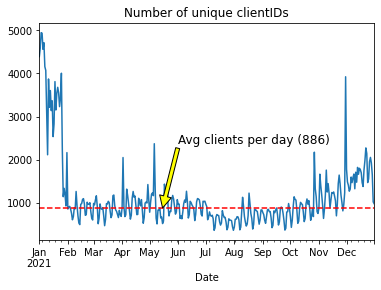

In [37]:
# extract clients per day = sum of unique IDs per day  
# df['Date'].value_counts().plot()
df.groupby('Date')['clientID'].nunique().plot()
plt.axhline(y = round(len(test1)/365, 2), color = 'r', linestyle = '--')
plt.title("Number of unique clientIDs")
# Annotation
plt.annotate('Avg clients per day (886)',
              xy = ('2021-05-15', round(len(test1)/365, 2)), 
              xytext =('2021-06-01', round(len(test1)/365, 2) + 1500), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [80]:
# number of clientIDs per source channel - ClientIDs are NOT unique in this case 
# multi-index with 3 columns 
df_grouped2 = df_grouped.reset_index()
print(df_grouped2)

0          Date        Channel group  Users  Transactions  Transaction revenue
0    2021-01-01              (Other)      1             0               0.0000
1    2021-01-01  Branded Paid Search    120            16            2614.7018
2    2021-01-01               Direct    145             5             644.4316
3    2021-01-01              Display   3557             0               0.0000
4    2021-01-01                Email      6             1              79.2334
...         ...                  ...    ...           ...                  ...
3441 2021-12-31  Generic Paid Search     19             0               0.0000
3442 2021-12-31       Organic Search    231            29            4239.5146
3443 2021-12-31             Referral     22             0               0.0000
3444 2021-12-31               Social     43             0               0.0000
3445 2021-12-31          YouTube Ads      8             0               0.0000

[3446 rows x 5 columns]


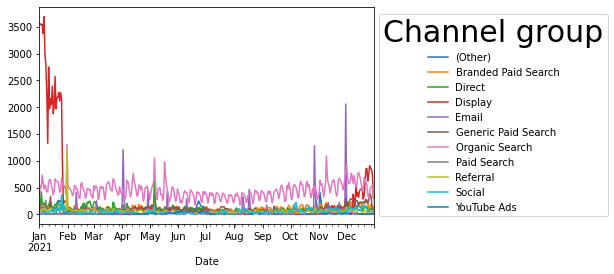

In [103]:
df_grouped.unstack()['Users'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Check transactions

In [16]:
# df of transactions (i.e. rows of transaction >= 1)
df_transactions = df[df['Transactions'] > 0]

In [17]:
print('Total number of transactions: ', df['Transactions'].sum())
print('Avg number of transactions per day:', round(df['Transactions'].sum()/365, 2))
df_transactions = df[df['Transactions'] > 0]
print('Total number of clientIDs with transactions:', len(df_transactions.clientID.value_counts()))
df_transactions_over1 = df[df['Transactions'] > 1]
print('Total number of clientIDs with more than 1 transaction:', len(df_transactions_over1.clientID.value_counts()))

Total number of transactions:  7651
Avg number of transactions per day: 20.96
Total number of clientIDs with transactions: 6616
Total number of clientIDs with more than 1 transaction: 382


Because that big peak at the end of peak was "weird", we checked results in year 2020 - looked the same. We then figured out that the peak is caused by #GivingTuesday. 
**Evtl. new goal - are results the same on #GivingTuesday as the rest of the year?**

Text(2021-07-01, 1000, '#GivingTuesday')

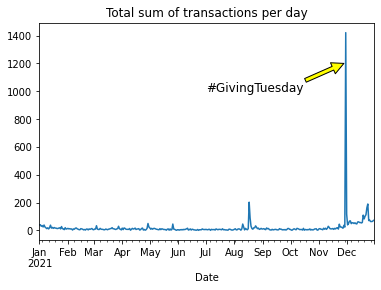

In [18]:
# check transactions per day 
df.groupby('Date')['Transactions'].sum().plot()
plt.title("Total sum of transactions per day")
# add annotation of #givingtuesday 
plt.annotate('#GivingTuesday',
              xy = ('2021-11-28', 1200), 
              xytext =('2021-07-01',1000), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))

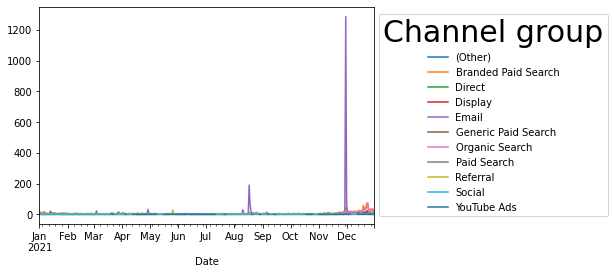

In [104]:
df_grouped.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [25]:
# check results without #GivingTuesday 
# impute transactions on GivingTuesday with second highest value 
df_no_giving_tuesday = df 
df_no_giving_tuesday = df_no_giving_tuesday.groupby(['Date'])['Transactions'].sum()
df_no_giving_tuesday[df_no_giving_tuesday > 1000]


Date
2021-11-30    1421
Name: Transactions, dtype: int64

In [27]:
max(df_no_giving_tuesday[df_no_giving_tuesday < 1000]) # 203
# substitute number of transactions in GivingTuesday with next max. value 
df_no_giving_tuesday[df_no_giving_tuesday > 1000] = max(df_no_giving_tuesday[df_no_giving_tuesday < 1000])

In [105]:
df_no_giving_tuesday

Date
2021-01-01    40
2021-01-02    41
2021-01-03    30
2021-01-04    35
2021-01-05    25
              ..
2021-12-27    64
2021-12-28    64
2021-12-29    65
2021-12-30    71
2021-12-31    75
Name: Transactions, Length: 365, dtype: int64

In [38]:
# check avg. number of transactions without giving tuesday 
avg_number_transactions_no_giving_tuesday = df_no_giving_tuesday.sum() / len(df_no_giving_tuesday)
avg_number_transactions_no_giving_tuesday

17.624657534246577

Even without #GivingTuesday, some peaks exist and an increase in the number of transactions at the end of the year. 

TODO 
Try to extract information about campaigns? 

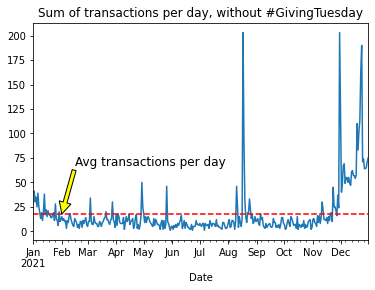

In [42]:
# check transactions per day - already grouped by date  
df_no_giving_tuesday.plot()
plt.axhline(y = avg_number_transactions_no_giving_tuesday, color = 'r', linestyle = '--')
plt.title("Sum of transactions per day, without #GivingTuesday")
# Annotation
plt.annotate('Avg transactions per day',
              xy = ('2021-02-01', avg_number_transactions_no_giving_tuesday), 
              xytext =('2021-02-15', avg_number_transactions_no_giving_tuesday + 50), 
              color='black',
              # fontweight='bold',
              fontsize = 12,
              arrowprops = dict(facecolor = 'yellow'))
plt.show()

In [106]:
df_no_giving_tuesday2 = df[df['Date'] != '2021-11-30']
# df_no_giving_tuesday2

In [107]:
# Create df_grouped without #GivingTuesday
df_grouped_no_giving_tuesday2 = df_no_giving_tuesday2.groupby(['Date', 'Channel group']).sum()
df_grouped_no_giving_tuesday2

0                               Users  Transactions  Transaction revenue
Date       Channel group                                                
2021-01-01 (Other)                  1             0               0.0000
           Branded Paid Search    120            16            2614.7018
           Direct                 145             5             644.4316
           Display               3557             0               0.0000
           Email                    6             1              79.2334
...                               ...           ...                  ...
2021-12-31 Generic Paid Search     19             0               0.0000
           Organic Search         231            29            4239.5146
           Referral                22             0               0.0000
           Social                  43             0               0.0000
           YouTube Ads              8             0               0.0000

[3436 rows x 3 columns]

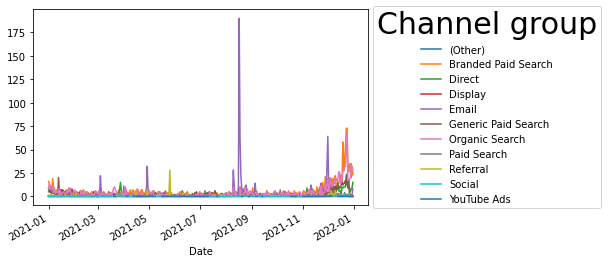

In [108]:
df_grouped_no_giving_tuesday2.unstack()['Transactions'].plot()
plt.legend(title='Channel group',title_fontsize=30,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### Check Channel group	

Make sure that order remains the same for all plots - to be able to compare them better

In [19]:
df['Channel group'].value_counts()

Organic Search         163654
Display                 89075
Branded Paid Search     42998
Direct                  38676
Generic Paid Search     35389
Referral                22787
Social                  17798
Email                   14878
(Other)                 12870
YouTube Ads              2883
Paid Search              1096
Name: Channel group, dtype: int64

In [20]:
# set order - depending on number of channel groups, per year and for all data 
order = ['Email', 'Branded Paid Search', 'Organic Search', 'Generic Paid Search', 'Direct', 'Referral', 'Social', 'Display', '(Other)', 'YouTube Ads', 'Paid Search']

In [21]:
df

,clientID,Date,Channel group,Users,Transactions,Transaction revenue
0,669558.1609495171,2021-01-01,Display,1,0,0.0
1,1090275.1606543939,2021-01-01,Display,1,0,0.0
2,1184473.1609510423,2021-01-01,Paid Search,1,0,0.0
3,1291193.1590344615,2021-01-01,Display,1,0,0.0
4,1309756.1608377368,2021-01-01,Display,1,0,0.0
...,...,...,...,...,...,...
442099,2042738099.1640943457,2021-12-31,Email,1,0,0.0
442100,2042766705.1635368625,2021-12-31,Email,1,0,0.0
442101,2043533916.1640950150,2021-12-31,Branded Paid Search,1,0,0.0
442102,2047304846.1640943758,2021-12-31,Email,1,0,0.0


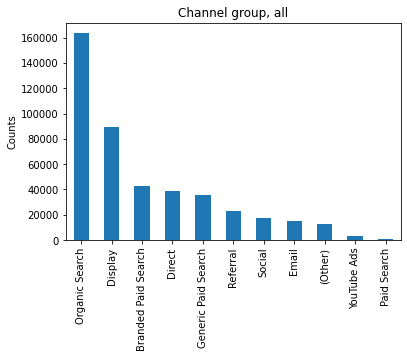

In [24]:
# plot of channel group 
#plt.subplot(1, 2, 1) # row 1, col 2 index 1

df['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, all')

#plt.subplot(1, 2, 2) # index 2
#df_transactions['Channel group'].value_counts().plot(kind='bar')
#plt.ylabel('Counts')
#plt.title('Channel group, just transactions')

# minimize overlap 
#plt.tight_layout()

plt.show()

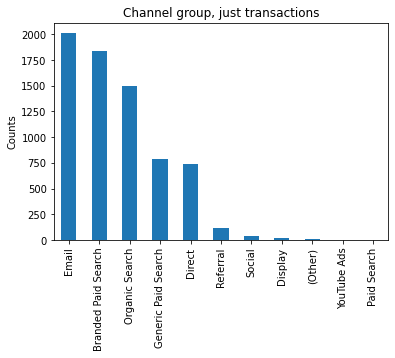

In [87]:
df_transactions['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, just transactions')
plt.show()

In [78]:
df_transactions

,clientID,Date,Channel group,Users,Transactions,Transaction revenue
67,25671893.1609535146,2021-01-01,Referral,1,1,52.8223
88,35090660.1576861447,2021-01-01,Direct,1,1,52.8223
474,205614325.1609497944,2021-01-01,Organic Search,1,1,79.2334
490,210709823.1609526226,2021-01-01,Direct,1,1,79.2334
727,319620508.1608232396,2021-01-01,Organic Search,1,1,701.3739
...,...,...,...,...,...,...
442042,1904420574.1596615171,2021-12-31,Organic Search,1,2,124.6605
442047,1911228715.1640980395,2021-12-31,Direct,1,1,36.9756
442052,1920995128.1640956026,2021-12-31,Organic Search,1,1,10.5645
442055,1928347173.1640978088,2021-12-31,Organic Search,1,1,5.2822


In [88]:
# build table of channels vs transaction revenue 
test1 = df_transactions[['Channel group', 'Transaction revenue']]
test1.loc[order].groupby('Channel group').sum().plot(kind = 'bar')
plt.show()

NameError: name 'order' is not defined

In [80]:
# revenue per channel 
# this code, but color by transaction revenue 
df_transactions['Channel group'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.title('Channel group, all')
plt.show() 

KeyError: ('Channel group', 'Transaction revenue')

#### Focus: #GivingTuesday (2021-11-30)

In previous plots we have seen that a peak exists in number of (unique) clients IDs, and specially on number of transactions. We therefore would like to check: 

* What is the "normal" ratio of transactions/client IDs, and what is the ratio on #GivingTuesday 

* What is the number of new client IDs (i.e. client IDs that did not appear in the dataset before that day, for the whole 2021)

* Transactions coming from new vs repeated client IDs 

* Proportion of source channels on #GivingTuesday vs rest of year 

In [56]:
# calculate avg. transactions per day without giving tuesday 
# transactions on givingtuesday 
df.groupby('Date')['Transactions'].sum()

Date
2021-01-01    0
2021-01-02    0
2021-01-03    0
2021-01-04    0
2021-01-05    0
             ..
2021-12-27    0
2021-12-28    0
2021-12-29    0
2021-12-30    0
2021-12-31    0
Name: Transactions, Length: 365, dtype: int64

In [50]:
test1 = df
test1.loc[test1.Date == '2021-11-29', 'Transactions'] = 0
test1[test1['Date'] == '2021-11-29']

,clientID,Date,Channel group,Users,Transactions,Transaction revenue
383484,1574488.1638226715,2021-11-29,Organic Search,1,0,0.0
383485,2530492.1638195637,2021-11-29,(Other),1,0,0.0
383486,4598290.1637363422,2021-11-29,Organic Search,1,0,0.0
383487,7245223.1638210762,2021-11-29,Branded Paid Search,1,0,0.0
383488,8604458.1638139613,2021-11-29,Organic Search,1,0,0.0
...,...,...,...,...,...,...
384809,2037204056.1638197916,2021-11-29,Branded Paid Search,1,0,0.0
384810,2037204056.1638197916,2021-11-29,Organic Search,1,0,0.0
384811,2039632098.1637698659,2021-11-29,Generic Paid Search,1,0,0.0
384812,2041151117.1638208413,2021-11-29,Branded Paid Search,1,0,0.0


In [37]:
# sum of transactions per day without #GivingTuesday 
df_without_giving_tuesday = df[df['Date' not in '2021-11-30']]
df_without_giving_tuesday.groupby('Date')['Transactions'].sum().plot()
plt.title("Total sum of transactions per day, without #GivingTuesday")


KeyError: True

In [47]:
# ----- ONGOING

print('Number of transactions from clientID that appear just once:')
print('Number of transactions from clientIDs that appear more than once:')

Number of transactions from clientID that appear just once:
Number of transactions from clientIDs that appear more than once:


TODO - se following code 

In [ ]:
# calculate for the whole year 2021
# Number of new/old users - from Supermetrics
# Number of transactions from new/old users 

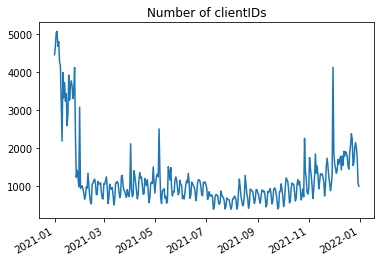

Something weird is happening on a single day in December

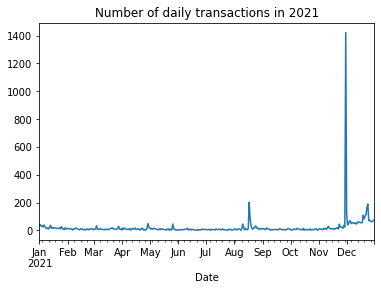

In [30]:
# extract number of transactions = sum of transactions per day
df.groupby(['Date'])['Transactions'].sum().plot()
plt.title('Number of daily transactions in 2021')
plt.show()

In [13]:
df2 = df[['Date', 'Transactions']]
df2 = df2.groupby(['Date'])['Transactions'].sum()

# 30.11.2021 1421 transactions exist. 
df2[df2 > 1000]

Date
2021-11-30    1421
Name: Transactions, dtype: int64

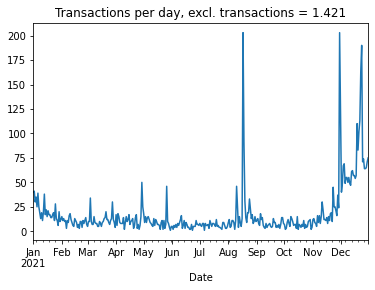

In [14]:
max(df2[df2 < 1000])
# substitute 1421 transactions with next max. value (203)
df2[df2 > 1000] = 203 
df2.plot()
plt.title('Transactions per day, excl. transactions = 1.421')
plt.show()


In [15]:
#print("transactions on 01.01.2021: ", len(df1.loc[(df1['Date'] == "2021-01-01") & (df1['Transactions'] >1)]))
#print("transactions on 02.01.2021:", len(df1[(df1['Date'] == "2021-01-02") & (df1['Transactions'] > 1)]))
#print("transactions on 03.01.2021:", len(df1[(df1['Date'] == "2021-01-03") & (df1['Transactions'] >=1)]))

In [16]:
# as reference, import data from 2020 and check number of daily transactions 
url_12months_2020 = constants_MT.url_12months_2020
response_12months_2020 = requests.get(url_12months_2020)
df_12months_2020 = url_to_df(url_12months_2020, response_12months_2020)
df_12months_2020 = transform_class(df_12months_2020)

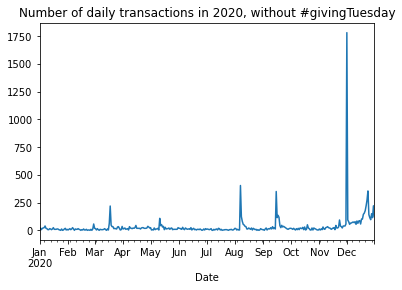

In [34]:
# check general trend in 2020 
df3 = df_12months_2020[['Date', 'Transactions']]
df3 = df3.groupby(['Date'])['Transactions'].sum()
df3.plot()
plt.title('Number of daily transactions in 2020, including #givingTuesday')
plt.show()

In [37]:
max(df3[df3 < 1000])
# substitute number of transactions in GivingTuesday with next max. value 
df3[df3 > 1000] = 404

In [ ]:
# check trend in 2020 without #givingTuesday 
df3 = df_12months_2020[['Date', 'Transactions']]
df3 = df3.groupby(['Date'])['Transactions'].sum()
df3.plot()
plt.title('Number of daily transactions in 2020, including #givingTuesday')
plt.show()

In 2020, the date with highest number of transactions of the year is 01.12.2020. As a reminder, that date was 30.11 in 2021. 

**That correspond to #givingTuesday 2020 (01.12) and 2021 (30.11)** 

TODO 
* Figure out if we should get rid of information/transactions on giving Tuesday - or just study the behavior on that specific day vs rest of days 
* Figure out if some other special marketing campaigns exist during the year and try to consider if they may have an effect on the analysis 
* Consider if substituting number of transactions in giving tuesday with value of second peak makes any sense 

In [29]:
df3[df3 > 1000]

Date
2020-12-01    1782
Name: Transactions, dtype: int64

In [33]:
df[df['Date'] == '30.11.2021']

c:\Users\carol\OneDrive\Escritorio\FH Kufstein\MT\analysis\python\venv_mt\lib\site-packages\pandas\core\arraylike.py:40: UserWarning: Parsing '30.11.2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return self._cmp_method(other, operator.eq)


,clientID,Date,Channel group,Users,Transactions,Transaction revenue
384814,780848.1638289758,2021-11-30,Email,1,1,79.2334
384815,909937.1636656983,2021-11-30,Email,1,1,21.1289
384816,1949950.1638258402,2021-11-30,Email,1,1,79.2334
384817,2073168.1638281792,2021-11-30,Generic Paid Search,1,0,0.0000
384818,2136460.1638305839,2021-11-30,Email,1,0,0.0000
...,...,...,...,...,...,...
388926,2043942088.1637656260,2021-11-30,Direct,1,0,0.0000
388927,2044422961.1638290305,2021-11-30,Email,1,1,264.1113
388928,2045311519.1608800768,2021-11-30,Email,1,1,105.6445
388929,2045356680.1630611955,2021-11-30,Organic Search,1,0,0.0000
